# Bootstrap Your Own Latent

* [**Paper**](https://arxiv.org/abs/2006.07733)

In this paper, the authors propose a new method for self-supervised representation learning. Briefly, they train an online network, which tries to predict the representation $\tilde{z}$ produced by the target network. Each network sees a different view $v_i$ and $v_i'$ (i.e. augmentation) of the datapoint $x_i$.

The parameters of target network $\xi$ is an exponential moving average of the parameters of the online network $\theta$:

$$
\xi_{t + 1} \leftarrow \tau \xi_t + (1 - \tau) \theta_t
$$

where $\tau \in [0, 1]$. In the original paper, the authors define $\tau_t$ at training step $t$ as:

$$
\tau_t = 1 - \frac{1}{2} (1 - \tau_0) \cos \left( \frac{t}{T} \pi \right)
$$

The online network then tries to predict the target network's representation, using the following loss function $L$:

$$
L = 2 \left(1 - \frac{\hat{\mathbf{z}}_i^T \tilde{\mathbf{z}}_j}{||\hat{\mathbf{z}}_i|| \cdot ||\tilde{\mathbf{z}}_j||}\right)
$$

i.e. 2 times the cosine distance between the two representations. (In the optimisation, we could just get rid of the factor 2, as it would be equivalent to using a higher learning rate)

In [1]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random
import tensorflow as tf
import tqdm
from sklearn import metrics

In [2]:
def normalise(x):
    z = x / jnp.linalg.norm(x, axis=-1, keepdims=True)
    return z


def cosine_distance(xi, xj):
    return 1 - jnp.einsum("ij,ij->i", normalise(xi), normalise(xj))


In [3]:
def init_layer(shape, rng):
    k0, k1 = jax.random.split(rng)
    return jax.random.normal(k0, shape), jax.random.normal(k1, shape[-1:])


In [4]:
def mlp(w, X):
    for i, (W, b) in enumerate(w):
        X = X @ W + b
        if i != (len(w) - 1):
            X = nn.relu(X)

    return X


def v(X, k):
    return X * jax.random.bernoulli(k, 0.9)


@jax.jit
def train_step(p0, p1, X, eta, rng):
    k0, k1 = jax.random.split(rng)

    def L(p):
        return jnp.mean(
            2 * cosine_distance(mlp(p, v(X, k0)), mlp(p1, v(X, k1)))
            # + 1e-4 * jax.tree_util.tree_reduce(lambda s, w: s + jnp.linalg.norm(w) ** 2, p, 0.0)
        )

    l, g = jax.value_and_grad(L)(p0)
    return update_params(p0, g, eta), l


def update_params(p, g, eta):
    return jax.tree_map(lambda w, G: w - eta * G, p, g)

In [5]:
rng = jax.random.PRNGKey(0)

In [6]:
r = rng
l0 = []
for l in [
    (28 ** 2, 512),
    (512, 256),
    (256, 64),
]:
    r, k = jax.random.split(r)
    l0.append(init_layer(l, k))

l1 = [init_layer((64, 64), r)]

In [7]:
def get_batch_indices(rng, dataset_size, batch_size):
    steps_per_epoch = dataset_size // batch_size

    perms = jax.random.permutation(rng, dataset_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    return perms

In [8]:
def get_target_network(p0, p1, tau):
    return jax.tree_map(lambda w0, w1: tau * w1 + (1 - tau) * w0, p0, p1)

def get_tau(base, k, K):
    return 1 - (1 - base) * 0.5 * (jnp.cos(jnp.pi * k / K) + 2)


In [9]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = jnp.array(X_train.reshape(len(X_train), -1) / 126)
X_test = jnp.array(X_test.reshape(len(X_test), -1) / 126)

In [10]:
r = rng
L0, L1 = l0, l1
xi = jax.tree_map(lambda _: jnp.zeros_like(_), L0)

E = 100
k = 0
K = len(X_train) // 128 * E
for e in range(E):
    r, r0 = jax.random.split(r)
    ix = get_batch_indices(r0, len(X_train), 128)
    I = tqdm.tqdm(ix, desc=f"Epoch {e}:")

    for i in I:
        k += 1

        xi = get_target_network(L0, xi, get_tau(0.996, k, K))
        p, l = train_step(L0 + L1, xi, X_train[i], eta=5e-3, rng=r)

        L0 = p[:-1]
        L1 = p[-1:]
        I.set_description(f"Epoch {e} (loss={l.item():.3f})")
        I.refresh()


Epoch 99 (loss=0.172): 100%|████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:06<00:00, 72.15it/s]


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import manifold

In [12]:
T = manifold.TSNE(n_components=2, random_state=42).fit_transform(np.array(mlp(L0, X_test)))

<AxesSubplot: xlabel='t0', ylabel='t1'>

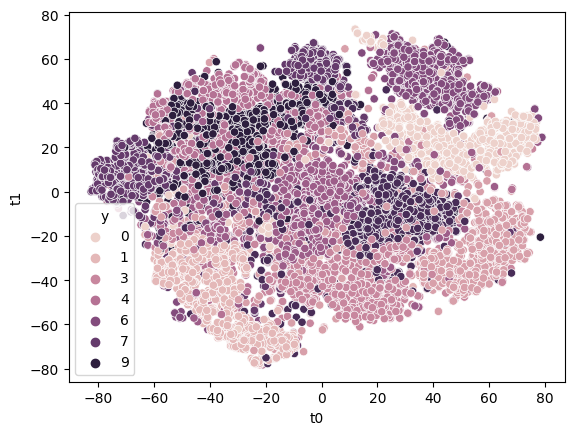

In [13]:
sns.scatterplot(
    data=pd.DataFrame(T, columns=["t0", "t1"]).assign(y=y_test),
    x="t0",
    y="t1",
    hue="y"
)

## Thoughts

This was a really nice, and easy paper to implement. Granted, I did not reproduce the actual results, as working with ImageNet is too computationally involved (for this project). But, it was easy to understand and clearly works. This seems like a promising technique for representation learning.

Also, I only tried augmenting via multiplying the inputs with Bernoulli random variables (i.e. Dropout), but other (more thorough) augmentations should also be tried (as mentioned in the paper).